# Model Training and Evaluation
Xinghan Yang and Tiger Yu

In [1]:

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder



## Step 1: Load Multiple CSV Files

In [2]:

twitch_capture_dir = './data/A/twitch_capture'
twitch_capture_speedtest_dir = './data/A/twitch_capture_speedtest'
vimeo_capture_dir= './data/A/vimeo_capture'
vimeo_capture_speedtest_dir = './data/A/vimeo_capture_speedtest'
youtube_capture_dir= './data/A/youtube_capture'
youtubecapture_speedtest_dir = './data/A/youtube_capture_speedtest'

twitch_files = glob.glob(os.path.join(twitch_capture_dir, '*.csv'))
twitch_speedtest_files = glob.glob(os.path.join(twitch_capture_speedtest_dir, '*.csv'))
vimeo_files = glob.glob(os.path.join(vimeo_capture_dir, '*.csv'))
vimeo_speedtest_files = glob.glob(os.path.join(vimeo_capture_speedtest_dir, '*.csv'))
youtube_files= glob.glob(os.path.join(youtube_capture_dir, '*.csv'))
youtube_speedtest_files = glob.glob(os.path.join(youtubecapture_speedtest_dir, '*.csv'))

all_files = twitch_files + twitch_speedtest_files + vimeo_files + vimeo_speedtest_files + youtube_files + youtube_speedtest_files
print("Number of files found:", len(all_files))

Number of files found: 28


## Step 2: Data Preparation
## Assume QoE is "good" if Flow Bytes/s is greater than 246.46604330741445 bytes/s

In [3]:
df_list= []
for f in all_files:
    df_temp = pd.read_csv(f)
    df_list.append(df_temp)

df = pd.concat(df_list, ignore_index=True)
print(df['Flow Bytes/s'].median())
df['QoE'] = df['Flow Bytes/s'] > 246.46604330741445

target = 'QoE'
if target not in df.columns:
    raise ValueError("The target column 'Flow Bytes/s was not found in the data.")

cols_to_drop = ['Flow ID', 'Src IP', 'Dst IP', 'Timestamp']
for c in cols_to_drop:
    if c in df.columns:
        df = df.drop(columns=c)

for col in df.columns:
    if df[col].dtype == object and col != target:
        df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.fillna(0)
X = df.drop(columns=[target])
y = df[target]
le = LabelEncoder()
y = le.fit_transform(y)
X = X.replace([np.inf, -np.inf], np.nan)

246.46604330741445


## Step 3: Training and Predicting

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.23, random_state=42)
clf = RandomForestClassifier(n_estimators=99, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


## Step 4: Evaluation

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        22
           1       1.00      0.94      0.97        16

    accuracy                           0.97        38
   macro avg       0.98      0.97      0.97        38
weighted avg       0.97      0.97      0.97        38



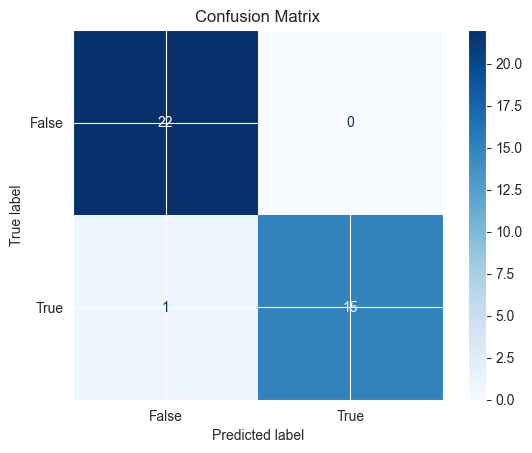

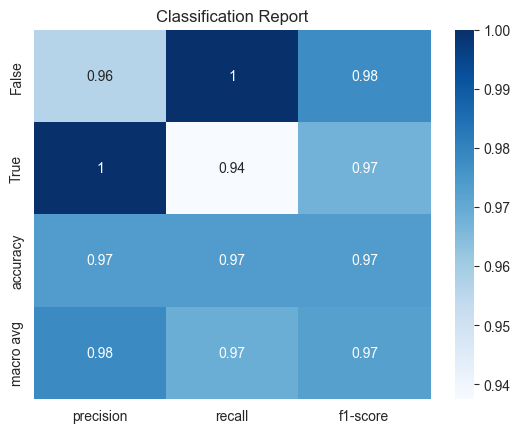

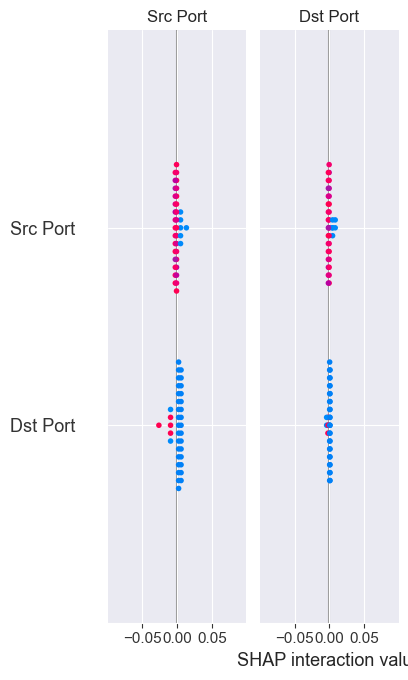

In [5]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

importances = clf.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

import seaborn as sns

report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
df_report = pd.DataFrame(report).transpose()
sns.heatmap(df_report.iloc[:-1, :3], annot=True, cmap="Blues")
plt.title("Classification Report")
plt.show()

import shap
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")